## **Object_Tracking_for_Social_Distancing**

In this file we wil try to create a social distancing tool based on facebook AI detectron 2 library.
## **Steps:**
1. Install Dependencies : Pytorch, Detectron 2
2. Import libraries
3. Reading a Video
4. Download the pre-trained model for object detection from Detectron 2’s model zoo
5. Read an image and pass it to the model for predictions:
6. understand the objects present in an image &  bounding boxes of each object
7. identify classes and bounding boxes related to only the people
8. Understand the format of the bounding box
9. Draw a bounding box for one of the people
10. compute the distance between two people in an image using bounding box
11. Define a function that returns the bottom center of every bounding box
12. Compute the bottom center for every bounding box and draw the points on the image
13. Define a function to compute the Euclidean distance between every two points in an image
14. Compute the distance between every pair of points
15. Define a function that returns the closest people
16. Set the threshold for the proximity distance
17. Define a function to change the color of the closest people to red
18. Carry out similar steps on each and every frame of the video
19. Define a function that performs all the steps we covered on each and every frame of the video
20. Identify the closest people in each frame and change the color to red
21. After identifying the closest people in each frame, convert the frames back to a video. 
That’s it!



# ***STEP -1 : Install Dependencies***

In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
# opencv is pre-installed on colab
!pip install -U torch==1.4 torchversion==0.5 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

#install detectron 2
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html



Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 753.4MB 21kB/s 
ERROR: Could not find a version that satisfies the requirement torchversion==0.5 (from versions: none)
ERROR: No matching distribution found for torchversion==0.5
     |████████████████████████████████| 276kB 13.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=1734b06ffd8e7e80c0f0ee6fcb2bf79730994e587b01436e30196999d7e0cb9c
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-xel0yg4n
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-xel0yg4n
  Created wheel for pycocotools: filename=pycocotools-2.

# ***Step 2: Import libraries***

In [0]:
#Importing the main library detectron
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

#import some common deterctron utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import  MetadataCatalog

#Import somee common libraries
import numpy as np
import cv2 
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt



# ***Step 3: Reading the video***

In [4]:
#specify Path to video
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
video = "/content/drive/My Drive/Deep_Learning_Social_Dist_Tool/sample.mp4"



In [0]:
#capture video
cap = cv2.VideoCapture(video)
cnt=0

#Check if the video is opened
if(cap.isOpened()==False):
  print("error in opening the video stream file")

ret,first_frame=cap.read()

#Read untill video is completed
while(cap.isOpened()):
  ret, frame=cap.read()

  if ret==True:
    #Save each frame to a folder
    cv2.imwrite('/content/drive/My Drive/Deep_Learning_Social_Dist_Tool/frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
    if cnt==750:
      break
  else:
      break



In [16]:
#Check the frame rate of a video:
FPS=cap.get(cv2.CAP_PROP_FPS)
print(FPS)

25.0


# ***Step 4: Download the pre-trained model for object detection from Detectron 2’s model zoo***

In [17]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.5.0+cu101 True


In [0]:
cfg=get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))

#Set threshold limit for this model. that is 90 percent object
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9 



In [12]:
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f97cb7.pkl: 136MB [00:14, 9.20MB/s]                           


# ***STEP 5: Read an image and pass it to the model for predictions:***

In [0]:
#Read an image
img=cv2.imread('/content/drive/My Drive/Deep_Learning_Social_Dist_Tool/frames/30.png')

In [0]:
#Pass it to the model
outputs=predictor(img)

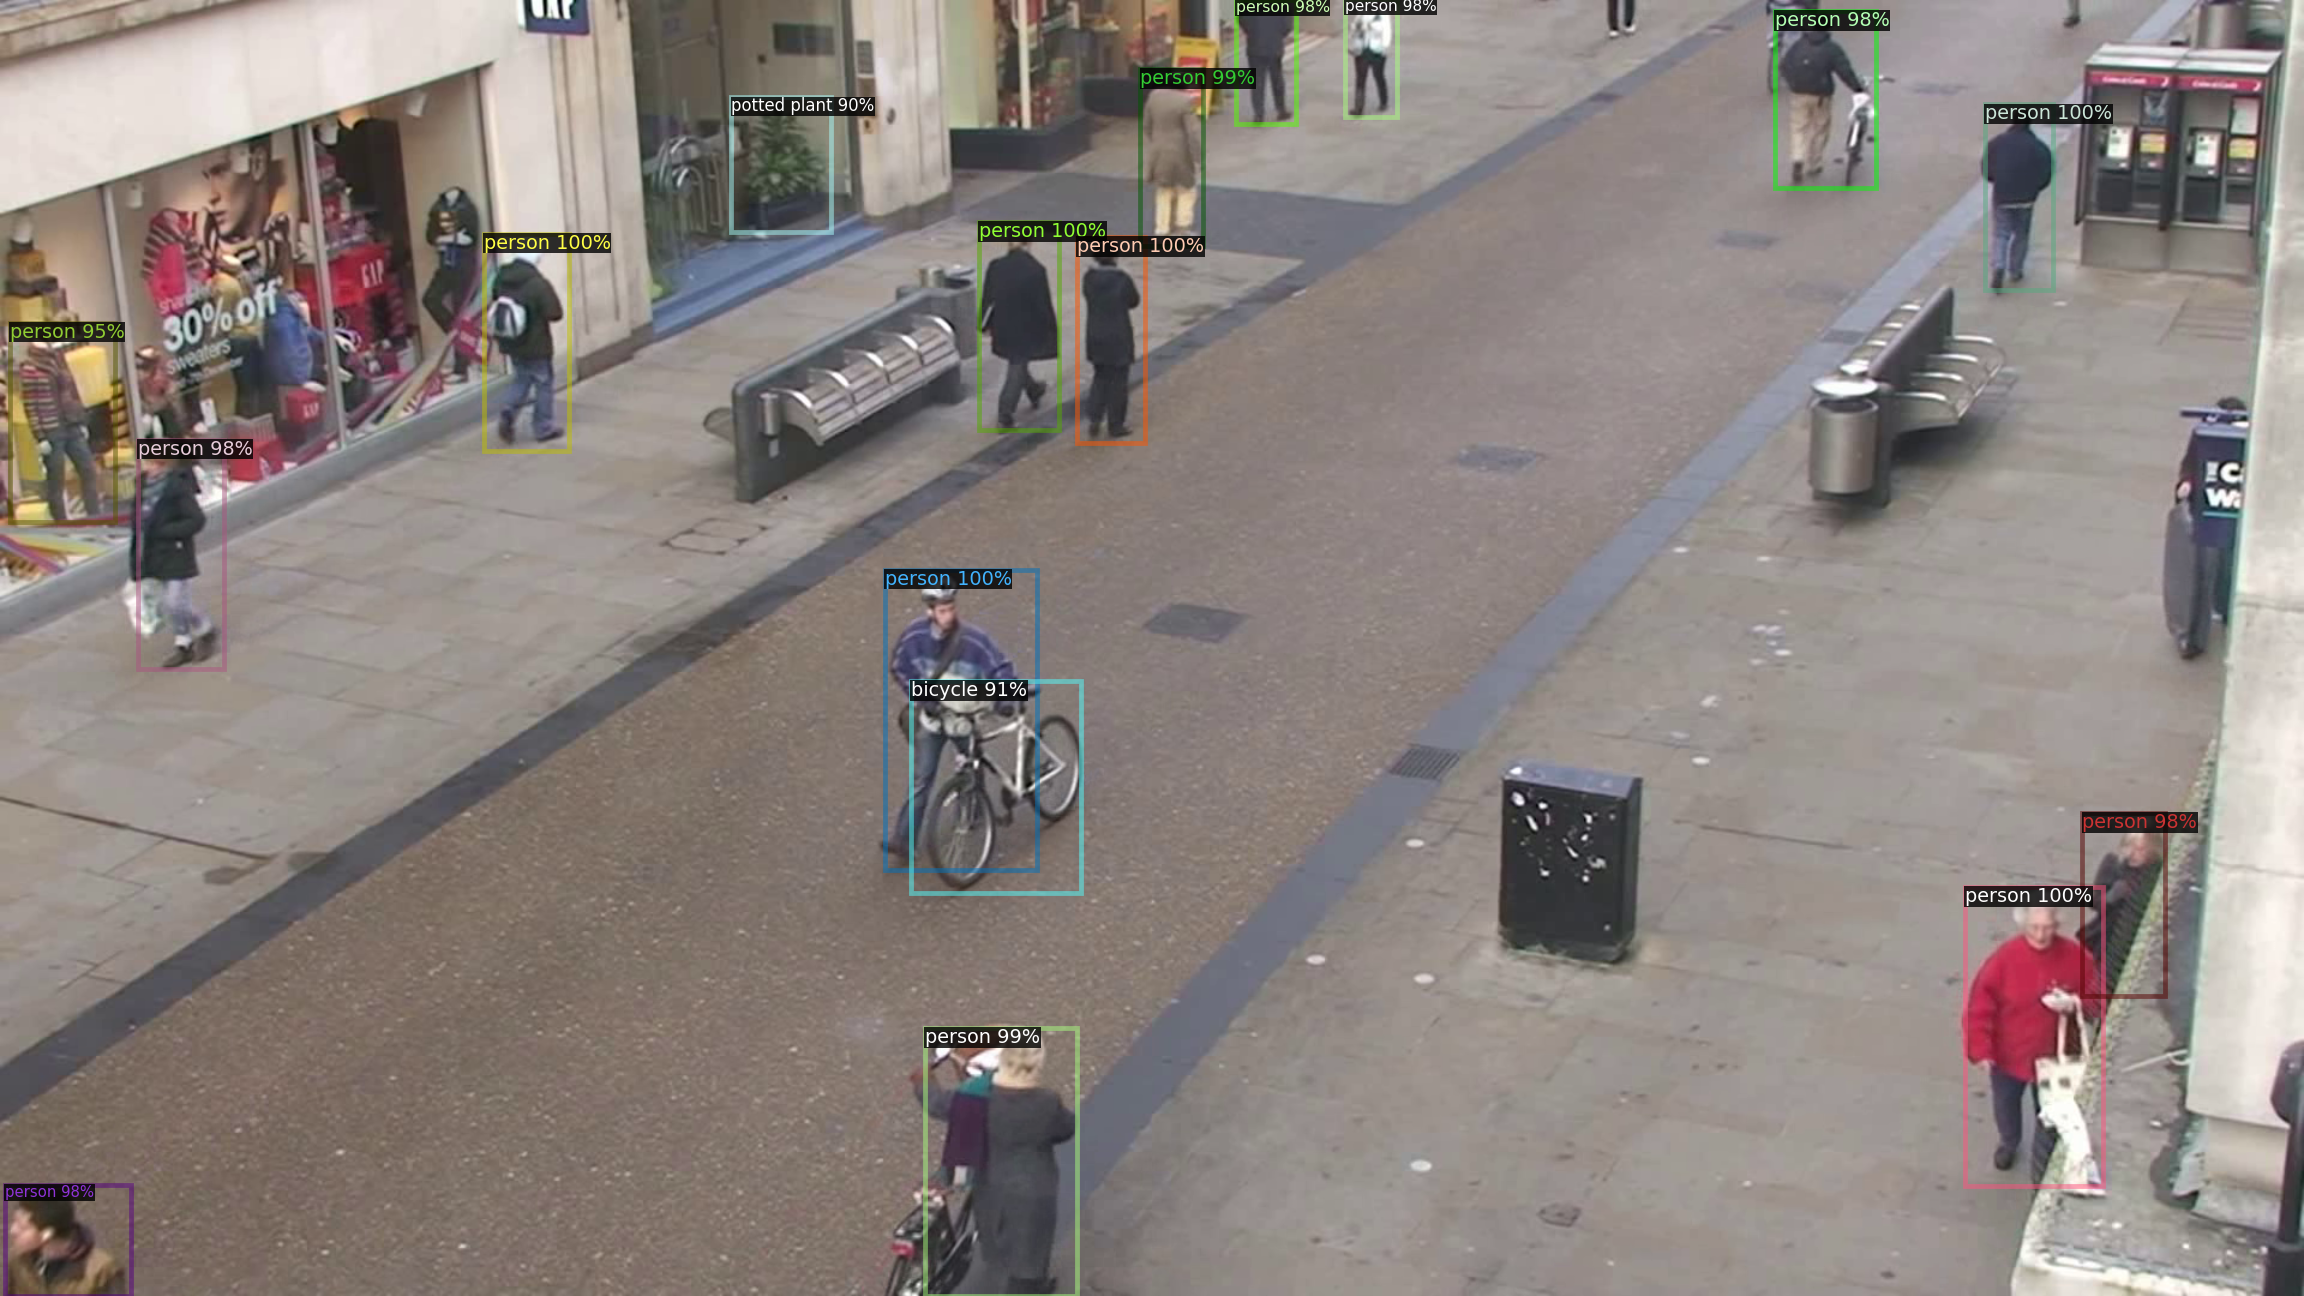

In [20]:
#Use Visualizer to draw predictions on the image
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

As you can see here, multiple objects are present in an image, like a person, bicycle, and so on. We are well on our way to building the social distancing detection tool!

# ***STEP 6: understand the objects present in an image & bounding boxes of each object***

In [21]:
classes=outputs['instances'].pred_classes.cpu().numpy()
print(classes)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 58]


Have a glance at the bounding boxes of each object:

In [22]:
bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[[8.97625732e+02 1.98114746e+02 9.54295410e+02 3.69938965e+02]
 [8.15539734e+02 1.85776886e+02 8.82243225e+02 3.58775421e+02]
 [7.37155457e+02 4.75216461e+02 8.64526733e+02 7.25281311e+02]
 [1.63727197e+03 7.39270691e+02 1.75216077e+03 9.88613037e+02]
 [4.02958832e+02 1.95546768e+02 4.74301331e+02 3.76508423e+02]
 [1.65389941e+03 8.78322067e+01 1.71117517e+03 2.42416138e+02]
 [9.50240295e+02 5.83510170e+01 1.00226202e+03 2.05864594e+02]
 [7.70899719e+02 8.57066589e+02 8.97423706e+02 1.08000000e+03]
 [1.14824585e+02 3.66958710e+02 1.86961533e+02 5.57881042e+02]
 [3.88901734e+00 9.87568298e+02 1.09564423e+02 1.08000000e+03]
 [1.73523938e+03 6.77691223e+02 1.80430774e+03 8.29950134e+02]
 [1.12059473e+03 0.00000000e+00 1.16453687e+03 9.86647034e+01]
 [1.47889429e+03 1.01930170e+01 1.56364978e+03 1.57773285e+02]
 [1.02976807e+03 1.21371460e+00 1.07966443e+03 1.04322647e+02]
 [8.13121223e+00 2.69681549e+02 9.55819016e+01 4.35993958e+02]
 [7.59207336e+02 5.68076111e+02 9.01112183e+02 7.441908

# ***STEP 7: dentify classes and bounding boxes related to only the people***

In [0]:
#identity only persons 
ind = np.where(classes==0)[0]

#identify bounding box of only persons
person=bbox[ind]

#total no. of persons
num= len(person)

# **STEP 8: Understand the format of the bounding box**

In [24]:
x1,y1,x2,y2 = person[0]
print(x1,y1,x2,y2)

897.62573 198.11475 954.2954 369.93896


# **STEP 9: Draw a bounding box for one of the people**

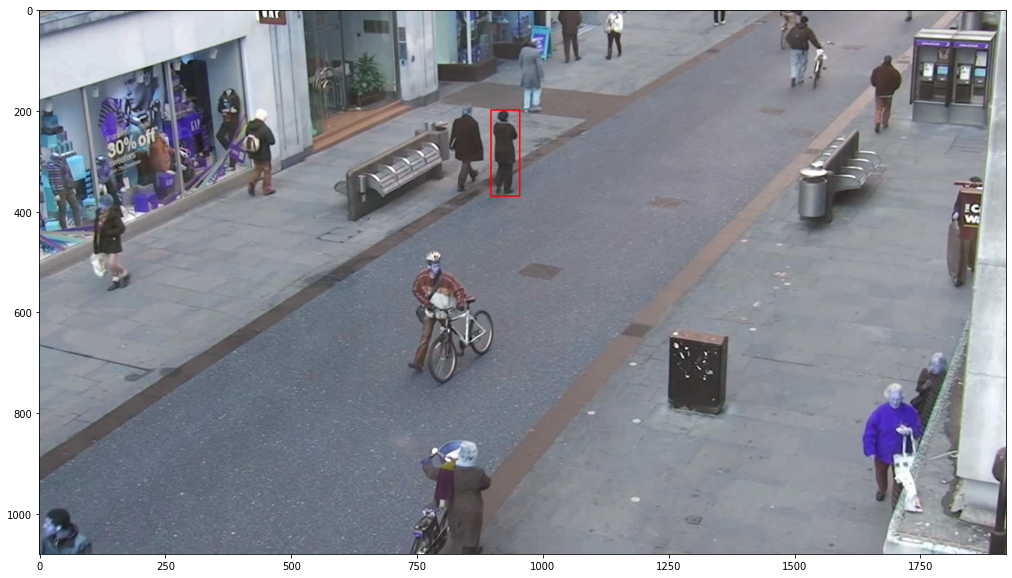

In [25]:
img=cv2.imread('/content/drive/My Drive/Deep_Learning_Social_Dist_Tool/frames/30.png')
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img)

Our ultimate goal is to compute the distance between two people in an image. Once we know the bounding box for each person, we can easily compute the distance between any two people. But the challenge here is to select the right coordinate for representing a person as a bounding box is in the form of a rectangle.

I have chosen the bottom center of a rectangle for representing each person to measure the distance accurately and also this measure is unaffected by the height of a person

# **STEP 10:compute the distance between two people in an image using bounding box**

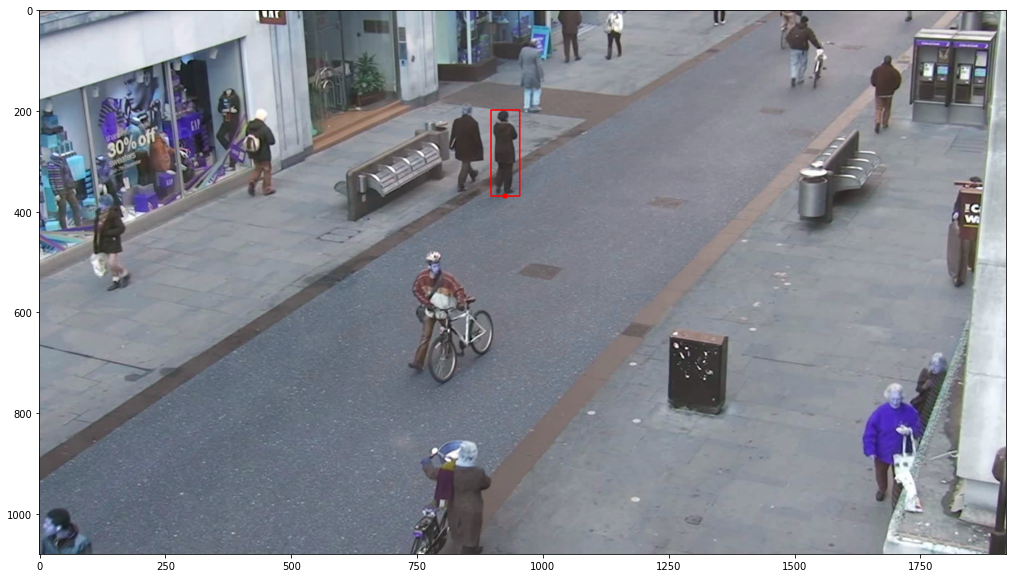

In [26]:
#compute center 
x_center = int((x1+x2)/2)
y_center = int(y2)

center = (x_center, y_center)

_ = cv2.circle(img, center, 5, (255, 0, 0), -1)
plt.figure(figsize=(20,10))
plt.imshow(img)

# **STEP 11:Define a function that returns the bottom center of every bounding box**

In [0]:
#define a function which return the bottom center of every bbox
def mid_point(img,person,idx):
  #get the coordinates
  x1,y1,x2,y2 = person[idx]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)
  
  #compute bottom center of bbox
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid   = (x_mid,y_mid)
  
  _ = cv2.circle(img, mid, 5, (0, 0, 255), -1)
  cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
  
  return mid


# **STEP 12: Compute the bottom center for every bounding box and draw the points on the image**

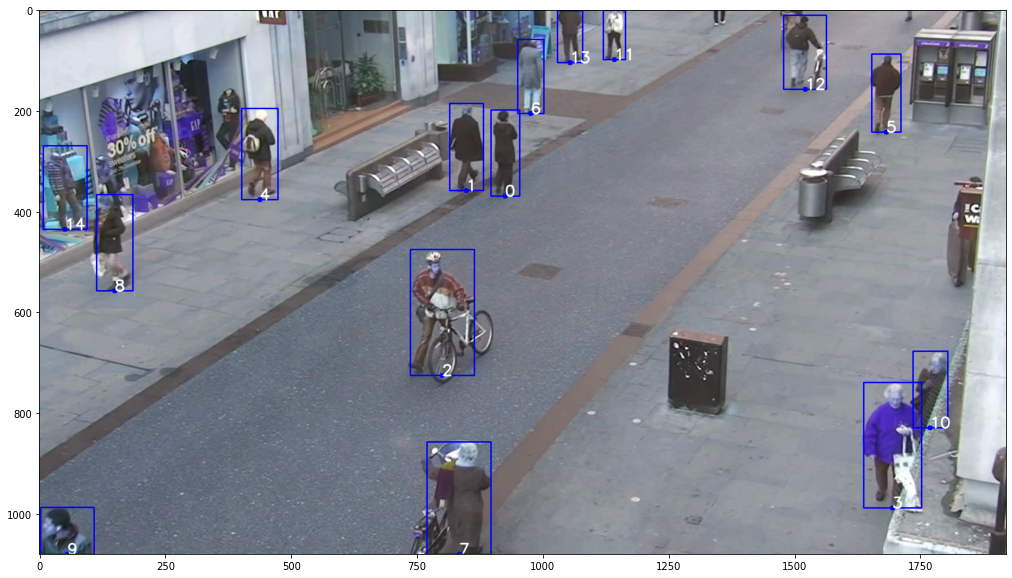

In [28]:
#call the function
midpoints = [mid_point(img,person,i) for i in range(len(person))]

#visualize image
plt.figure(figsize=(20,10))
plt.imshow(img)


# **STEP 13:** Define a function to compute the Euclidean distance between every two points in an image

In [29]:
%%time
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist


CPU times: user 65.6 ms, sys: 8.04 ms, total: 73.6 ms
Wall time: 75.8 ms


# **STEP 14:** Compute the distance between every pair of points

In [0]:
dist= compute_distance(midpoints,num)

# **STEP 15: Define a function that returns the closest people**
Define a function that returns the closest people based on the given proximity distance. Here, proximity distance refers to the minimum distance between two people:



In [31]:
%%time
def find_closest(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1,p2,d

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


# **STEP 16:** Set the threshold for the proximity distance
Set the threshold for the proximity distance. Here, I have chosen that to be 100. Let’s find the people who are within the proximity distance:

In [32]:
import pandas as pd

thresh=100
p1,p2,d=find_closest(dist,num,thresh)
df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
df

p1  p2       dist
0   0   1  77.781746
1  11  13  88.204308

From the output, we can observe that 4 people come under the red zone as the distance between them is less than the proximity threshold.

STEP 17: Define a function to change the color of the closest people to red:

In [0]:
def change_2_red(img,person,p1,p2):
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)  
  return img

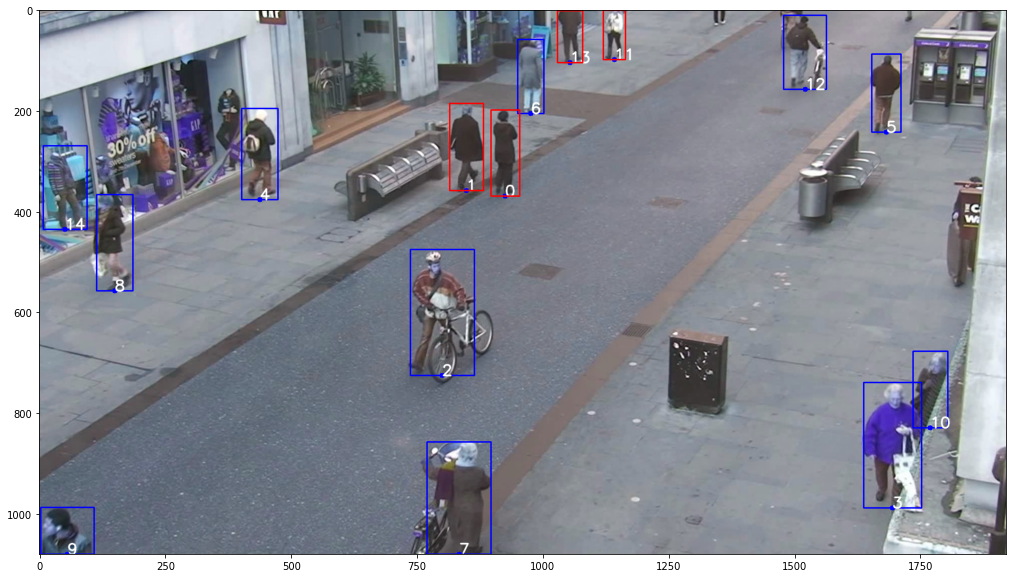

In [34]:
#Let’s change the color of the closest people to red:
img = change_2_red(img,person,p1,p2)

plt.figure(figsize=(20,10))
plt.imshow(img)

So far, we have seen a step by step procedure on how to apply object detection using Detectron-2, compute the distance between every pair of people, and then finally identify the closest people. We will carry out similar steps on each and every frame of the video now:

# **STEP 17:** Carry out similar steps on each and every frame of the video

In [0]:
import os
import re

names=os.listdir('/content/drive/My Drive/Deep_Learning_Social_Dist_Tool/frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

# **STEP 18: Define a function that performs all the steps we covered on each and every frame of the video**

In [0]:
def find_closest_people(name,thresh):

  img = cv2.imread('/content/drive/My Drive/Deep_Learning_Social_Dist_Tool/frames/'+name)
  outputs = predictor(img)
  classes=outputs['instances'].pred_classes.cpu().numpy()
  bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
  ind = np.where(classes==0)[0]
  person=bbox[ind]
  midpoints = [mid_point(img,person,i) for i in range(len(person))]
  num = len(midpoints)
  dist= compute_distance(midpoints,num)
  p1,p2,d=find_closest(dist,num,thresh)
  img = change_2_red(img,person,p1,p2)
  cv2.imwrite('/content/drive/My Drive/Deep_Learning_Social_Dist_Tool/frames/'+name,img)
  return 0

# **STEP 19:** Identify the closest people in each frame and change the color to red

In [38]:
from tqdm import tqdm
thresh=100
_ = [find_closest_people(names[i],thresh) for i in tqdm(range(len(names))) ]

100%|██████████| 750/750 [08:22<00:00,  1.49it/s]


# **STEP 20: After identifying the closest people in each frame, convert the frames back to a video**

In [41]:
%%time
frames = os.listdir('/content/drive/My Drive/Deep_Learning_Social_Dist_Tool/frames/')
# frames='/content/drive/My Drive/Deep_Learning_Social_Dist_Tool/frames/'
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
    
    #reading each files
    img = cv2.imread('/content/drive/My Drive/Deep_Learning_Social_Dist_Tool/frames/'+frames[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('/content/drive/My Drive/Deep_Learning_Social_Dist_Tool/sample_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

CPU times: user 43.9 s, sys: 11.3 s, total: 55.2 s
Wall time: 56.4 s
